In [1]:
import torch
from datasets import load_mnist, get_observation_pixels
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

BATCH_SIZE = 128
train_loader, test_loader, val_loader = load_mnist(BATCH_SIZE)

from config import load_config, get_model_name
config = load_config("vae")

model_name = get_model_name(config)

In [2]:
from trainers import BaseModule
from models import PixelConditionedVAE


class PixelVAETrainer(BaseModule):
    def __init__(self, hidden_dims = [128, 256], latent_dim = 2):
        model = PixelConditionedVAE(hidden_dims, latent_dim)
        super(PixelVAETrainer, self).__init__(model)
        self.save_hyperparameters()
        
    def forward(self, x, x_cond, y):
        return self.model(x,x_cond)
    
    def step(self, batch, batch_idx, mode = 'train'):
        x, x_cond, y = batch
        x_hat, mu, log_var, z = self(x, x_cond, y)
        loss = self.model.loss(x, x_hat, mu, log_var)
        self.log_dict({f"{mode}_{key}": val.item() for key, val in loss.items()}, sync_dist=True)
        return loss['loss']
    
    def load_model_checkpoint(model_name):
        path = ('checkpoints/' + model_name + '.ckpt')
        return PixelVAETrainer.load_from_checkpoint(path)

In [3]:
model = PixelVAETrainer(**config['model_params'])

from trainers import SuperTrainer
trainer = SuperTrainer(**config['trainer_params'], model_name=model_name)
trainer.fit(model, train_loader, val_loader)
#save
trainer.save_model_checkpoint()

/Home/siv34/edzak2974/.conda/envs/pytorch_masters/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /Home/siv34/edzak2974/.conda/envs/pytorch_masters/li ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Home/siv34/edzak2974/.conda/envs/pytorch_masters/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /Home/siv34/edzak2974/.conda/envs/pytorch_masters/li ...
  rank_zero_warn(
You are using a CUDA device ('A100-S

Epoch 49: 100%|██████████| 469/469 [00:06<00:00, 74.99it/s, v_num=1]       

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 469/469 [00:06<00:00, 70.66it/s, v_num=1]


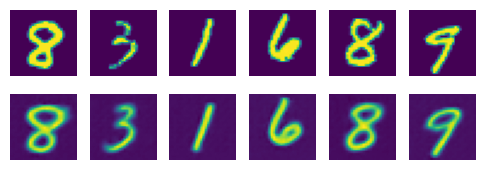

In [4]:
model = PixelVAETrainer.load_model_checkpoint(model_name)
model.eval()

from plotting import plot_samples_with_reconstruction

plot_samples_with_reconstruction(model, next(iter(test_loader)))